## Exploratory data analysis of rings

### Importing the libraries

In [32]:
# Importing libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10

### Importing the dataset

In [52]:
# Importing the dataset
rings_df = pd.read_csv('../data/rings_frequency_lipinski.csv')
rings_df.head(10)

,SMILES,n,chemical_name
0,c1ccccc1,478,benzene
1,c1ccncc1,78,pyridine
2,C1CCNCC1,52,piperidine
3,C1CCNC1,44,pyrrolidine
4,C1CNCCN1,42,piperazine
5,c1cncnc1,37,pyrimidine
6,C1CCOCC1,35,oxane
7,C1CC1,30,cyclopropane
8,c1ccc2[nH]ccc2c1,24,1h-indole
9,C1CCCCC1,23,cyclohexane


### 'Structure-frequency Cliffs'

In [9]:
# Testing and trying some stuff
rings_df['log_f'] = rings_df.n.apply(lambda x: round(log10(x),2))
rings_more_than_once = rings_df[rings_df['log_f'] >= 0.1]
rings_more_than_once.head(10)

,SMILES,n,chemical_name,log_f
0,c1ccccc1,478,benzene,2.68
1,c1ccncc1,78,pyridine,1.89
2,C1CCNCC1,52,piperidine,1.72
3,C1CCNC1,44,pyrrolidine,1.64
4,C1CNCCN1,42,piperazine,1.62
5,c1cncnc1,37,pyrimidine,1.57
6,C1CCOCC1,35,oxane,1.54
7,C1CC1,30,cyclopropane,1.48
8,c1ccc2[nH]ccc2c1,24,1h-indole,1.38
9,C1CCCCC1,23,cyclohexane,1.36


### Calculating the distance matrix of the compounds

In [26]:
# Transforming the SMILES
smiles_list_test = list(rings_more_than_once.SMILES)
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list_test]

# Generating Morgan fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]

# Computing the pairwise distance matrix
dist_mat = np.zeros((len(fps), len(fps)))
for i in range(len(fps)):
    for j in range(i+1, len(fps)):
        dist_mat[i,j] = 1 - DataStructs.DiceSimilarity(fps[i],fps[j])
        dist_mat[j,i] = dist_mat[i,j]

### Heatmap

<function matplotlib.pyplot.show(close=None, block=None)>

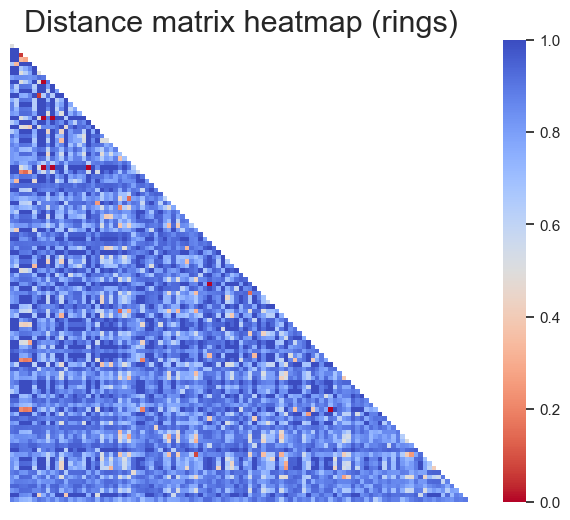

In [51]:
# mask to print out only the upper triangle
mask = np.zeros_like(dist_mat)
mask[np.triu_indices_from(mask)] = True

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.set_context('talk')
sns.set_theme(style="white")
sns.heatmap(dist_mat, annot=False, cmap='coolwarm_r', square=True, mask=mask)
plt.title('Distance matrix heatmap (rings)', size=22)

ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show

In [12]:
# Define a function to calculate similarity index and activity value difference
def calc_similarity_and_activity_difference(smiles_list, frequency_list):
    # Generate Morgan fingerprints
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]
    
    # Calculate pairwise similarity and activity difference
    sim_list = []
    frequency_diff_list = []
    smi_1_list = []
    smi_2_list = []
    for i in range(len(fps)):
        for j in range(i+1, len(fps)):
            sim = DataStructs.DiceSimilarity(fps[i], fps[j])
            freqdiff = abs(frequency_list[i] - frequency_list[j])
            sim_list.append(sim)
            frequency_diff_list.append(freqdiff)
            smi_1_list.append(smiles_list[i])
            smi_2_list.append(smiles_list[j])
    
    # Return the similarity and activity difference lists
    return sim_list, frequency_diff_list, smi_1_list, smi_2_list

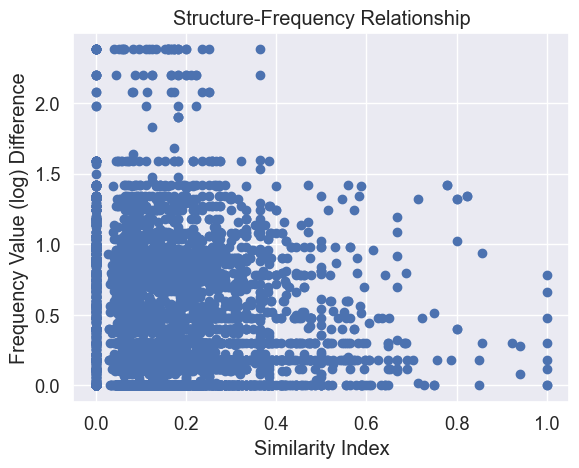

In [13]:
# Extract the SMILES strings and activity values
smiles_list = rings_more_than_once['SMILES'].tolist()
frequency_list = rings_more_than_once['log_f'].tolist()

# Calculate the similarity and activity difference
similarity_list, frequency_difference_list, smi_1, smi_2 = calc_similarity_and_activity_difference(smiles_list, frequency_list)

# Plot the similarity and activity difference
plt.scatter(similarity_list, frequency_difference_list)
plt.xlabel('Similarity Index')
plt.ylabel('Frequency Value (log) Difference')
plt.title('Structure-Frequency Relationship')
plt.show()


In [14]:
# As a dataframe:
frequency_cliffs_dict = {'similarity': similarity_list, 'frequency_log_diff': frequency_difference_list,
                         'smiles_1': smi_1, 'smiles_2': smi_2}

# Frequency
frequency_cliffs_df = pd.DataFrame.from_dict(frequency_cliffs_dict)
frequency_cliffs_df

,similarity,frequency_log_diff,smiles_1,smiles_2
0,0.500000,0.79,c1ccccc1,c1ccncc1
1,0.000000,0.96,c1ccccc1,C1CCNCC1
2,0.000000,1.04,c1ccccc1,C1CCNC1
3,0.000000,1.06,c1ccccc1,C1CNCCN1
4,0.333333,1.11,c1ccccc1,c1cncnc1
...,...,...,...,...
5248,0.121212,0.00,c1ccc2c(c1)C[C@H]1CN3[C@H]4COCCCS[C@H](c5ccc6c...,C1CO1
5249,0.106667,0.00,c1ccc2c(c1)C[C@H]1CN3[C@H]4COCCCS[C@H](c5ccc6c...,C1=NCCN1
5250,0.160000,0.00,B1OCc2ccccc21,C1CO1
5251,0.117647,0.00,B1OCc2ccccc21,C1=NCCN1


In [15]:
import plotly.express as px
fig = px.scatter(frequency_cliffs_df, x="similarity", y="frequency_log_diff", hover_data=['smiles_1', 'smiles_2'])
fig.show()

In [16]:
spotted = frequency_cliffs_df.query('similarity >= 0.6 & frequency_log_diff >= 0.5')

In [17]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(spotted, 'smiles_1', 'smiles_1_mol')
PandasTools.AddMoleculeColumnToFrame(spotted, 'smiles_2', 'smiles_2_mol')

/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:422: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:422: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,similarity,frequency_log_diff,smiles_1,smiles_2,smiles_1_mol,smiles_2_mol
131,0.666667,1.19,c1ccncc1,c1cnccn1,,
229,0.800000,1.02,C1CCNCC1,C1CNC1,,
271,0.777778,1.42,C1CCNCC1,C1CNCCNC1,,
282,0.777778,1.42,C1CCNCC1,C1CNCCNCCCNCCNC1,,
328,0.857143,0.94,C1CCNC1,C1CNC1,,
370,0.823529,1.34,C1CCNC1,C1CNCCNC1,,
381,0.823529,1.34,C1CCNC1,C1CNCCNCCCNCCNC1,,
426,0.666667,0.92,C1CNCCN1,C1CNC1,,
464,0.714286,1.32,C1CNCCN1,C1CNCN1,,
468,0.800000,1.32,C1CNCCN1,C1CNCCNC1,,

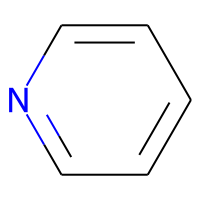
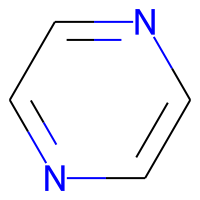
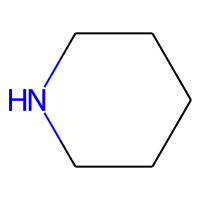
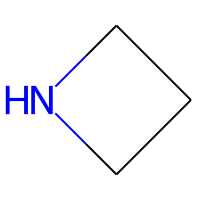
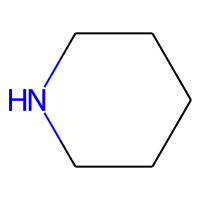
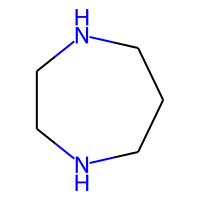
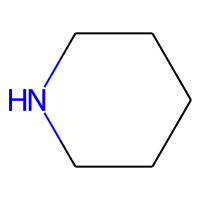
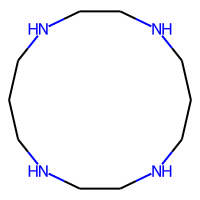
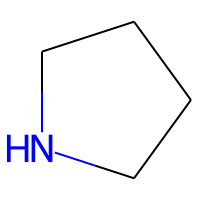
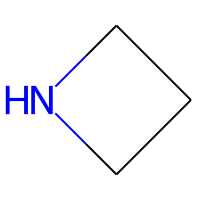
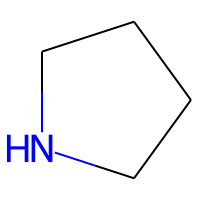
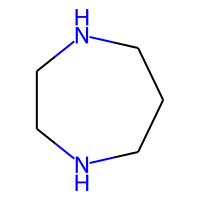
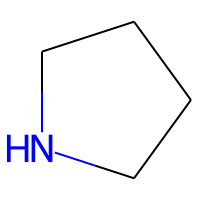
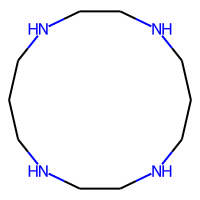
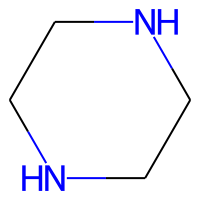
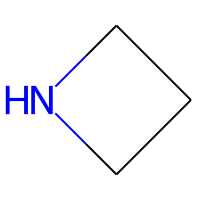
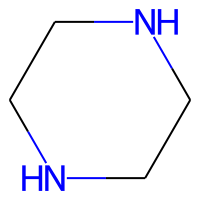
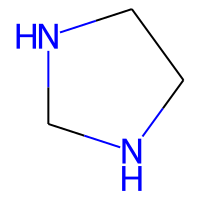
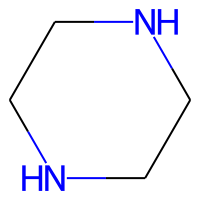
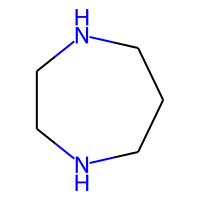
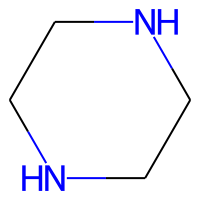
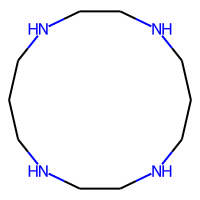
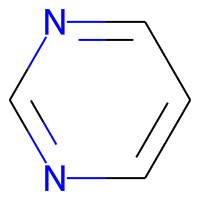
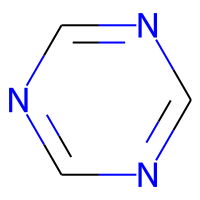
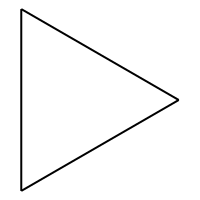
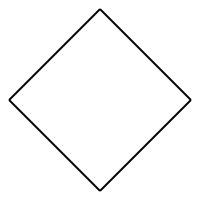
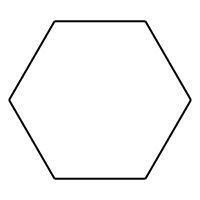
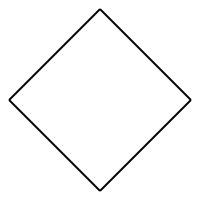
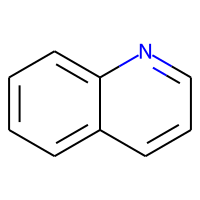
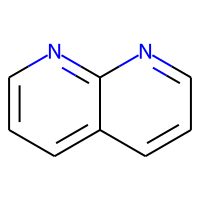
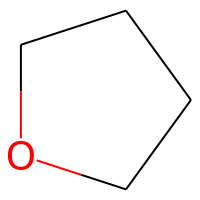
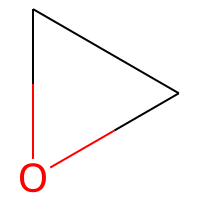
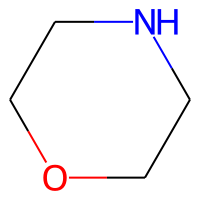
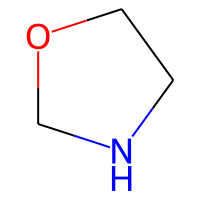
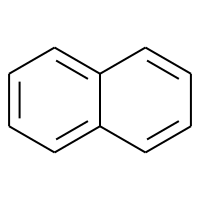
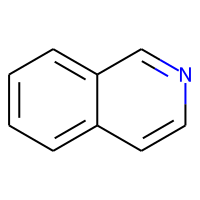
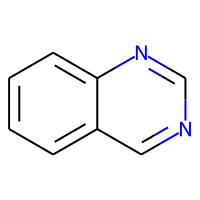
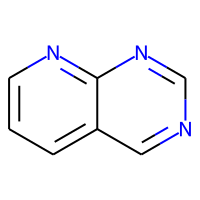

In [18]:
spotted